# Enrich Store Locations

Enriching store locations from a Web GIS Feature Layer is a very common workflow. Here, we detail how to enrich store locations both using current capabilities (v2.0.0) and soon to be released capabilties (v2.0.1).

In [1]:
from arcgis.gis import GIS
from arcgis.features import GeoAccessor
from arcgis.geoenrichment import get_countries, Country
from arcgis.features import use_proximity
from arcgis.features.use_proximity import create_drive_time_areas
from arcgis.features.enrich_data import enrich_layer
from IPython.display import display
import pandas as pd

## Setup

### Using Python-DotEnv

To not inadvertantly share a credentials, I make a habit of using the `python-dotenv` package. The url, username and password are saved in a file called `.env` in the project directory, and this file is always excluded from version tracking in the `.gitignore` file. The contents of the `.env` file are really simple.

```
    ESRI_GIS_URL = https://raddudes.maps.arcgis.com
    ESRI_GIS_USERNAME = oneRadDude
    ESRI_GIS_PASSWORD = P@$$w0rd
```

In [2]:
import os

from dotenv import find_dotenv, load_dotenv

# recursively crawls up directories until finding a .env file, and then loads it
load_dotenv(find_dotenv())

url = os.getenv('ESRI_GIS_URL')
usrnm = os.getenv('ESRI_GIS_USERNAME')
pswd = os.getenv('ESRI_GIS_PASSWORD')

### Parameterizing

To make the notebook a little more portable, this cell is where values unique to your specific data or preferences can be easily modified.

In [3]:
stores_itm_id = '3adf57606db84d7e81240479347907e1'

### Create GIS Object Instance

Now, to get to data and services, we need a connection to a Web GIS. This is accomplished by connecting to ArcGIS Online in this case through the GIS object.

In [4]:
gis =GIS(url, username=usrnm, password=pswd)

gis

GIS @ https://bateam.maps.arcgis.com version:9.4

## Get Store Locations

### Create Item Instance

We now get the reference to the Item in the Web GIS using the `stores_itm_id` from above.

<Item title:"locations" type:Feature Layer Collection owner:jmccune_bateam>
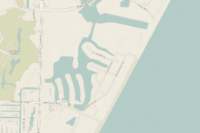

In [5]:
stores_itm = gis.content.get(stores_itm_id)

stores_itm

### Get the Layer

The item only saves the reference to the layer, and the layer is how we access data, so we need to get the first layer saved as part of the item (the only layer) to access the data.

In [6]:
stores_lyr = stores_itm.layers[0]

stores_lyr

<FeatureLayer url:"https://services8.arcgis.com/cOQY5d2zYaXw1BYI/arcgis/rest/services/locations/FeatureServer/0">

### Get the Data

Now, we can retrieve and examine the data.

In [7]:
stores_df = stores_lyr.query(
    out_fields=['LOCNUM']   # this only really applies to this demonstration if you're using your own data, so please feel free to remove
).sdf

stores_df.info()
stores_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  6 non-null      int64   
 1   LOCNUM    6 non-null      object  
 2   SHAPE     6 non-null      geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 272.0+ bytes


,OBJECTID,LOCNUM,SHAPE
0,1,164204208,"{""x"": -97.37453699999998, ""y"": 27.712800000000..."
1,2,402166529,"{""x"": -97.323093, ""y"": 27.71141400000015, ""spa..."
2,3,720384210,"{""x"": -97.36875000000002, ""y"": 27.709965000000..."
3,4,736055028,"{""x"": -97.37815552999999, ""y"": 27.682539720000..."
4,5,743788118,"{""x"": -97.63392599999996, ""y"": 27.855611999999..."


## Enrich Data

### Create a Country

Since working with in the United States, we need a Country object instance referencing the USA to access this data.

In [8]:
usa = Country('usa')

usa

<Country - United States (GIS @ https://bateam.maps.arcgis.com version:9.4)>

### Filter to Variables of Interest

With over 19 thousand variables available, we are going to reduce it to something at least under 100.

In [9]:
ev = usa.enrich_variables

print(f'Total Available {usa.properties.country_name} Enrichment Variables: {len(ev.index):,}')

enrich_vars = ev[ev.data_collection == 'tapestryhouseholdsNEW'].drop_duplicates('name').reset_index(drop=True)

enrich_vars

Total Available United States Enrichment Variables: 19,153


,name,alias,data_collection,enrich_name,enrich_field_name,description,vintage,units
0,TSEGNUM,2021 Dominant Tapestry Number,tapestryhouseholdsNEW,tapestryhouseholdsNEW.TSEGNUM,tapestryhouseholdsNEW_TSEGNUM,2021 Dominant Tapestry Number (Esri),2021,count
1,TSEGCODE,2021 Dominant Tapestry Segment,tapestryhouseholdsNEW,tapestryhouseholdsNEW.TSEGCODE,tapestryhouseholdsNEW_TSEGCODE,2021 Dominant Tapestry Segment (Esri),2021,text
2,TSEGNAME,2021 Dom Tapestry Segment Name,tapestryhouseholdsNEW,tapestryhouseholdsNEW.TSEGNAME,tapestryhouseholdsNEW_TSEGNAME,2021 Dominant Tapestry Segment Name (Esri),2021,text
3,THHBASE,2021 Tapestry Household Base,tapestryhouseholdsNEW,tapestryhouseholdsNEW.THHBASE,tapestryhouseholdsNEW_THHBASE,2021 Households by Tapestry Segment Base,2021,count
4,THH01,2021 HHs in Tapestry Seg 1A,tapestryhouseholdsNEW,tapestryhouseholdsNEW.THH01,tapestryhouseholdsNEW_THH01,2021 Top Tier (1A) Tapestry Households (Esri),2021,count
...,...,...,...,...,...,...,...,...
87,THHGRPU2,2021 HHs: Urbanization Group 2,tapestryhouseholdsNEW,tapestryhouseholdsNEW.THHGRPU2,tapestryhouseholdsNEW_THHGRPU2,2021 Urban Periphery Tapestry Urbanization Gro...,2021,count
88,THHGRPU3,2021 HHs: Urbanization Group 3,tapestryhouseholdsNEW,tapestryhouseholdsNEW.THHGRPU3,tapestryhouseholdsNEW_THHGRPU3,2021 Metro Cities Tapestry Urbanization Group ...,2021,count
89,THHGRPU4,2021 HHs: Urbanization Group 4,tapestryhouseholdsNEW,tapestryhouseholdsNEW.THHGRPU4,tapestryhouseholdsNEW_THHGRPU4,2021 Suburban Periphery Tapestry Urbanization ...,2021,count
90,THHGRPU5,2021 HHs: Urbanization Group 5,tapestryhouseholdsNEW,tapestryhouseholdsNEW.THHGRPU5,tapestryhouseholdsNEW_THHGRPU5,2021 Semirural Tapestry Urbanization Group U5 ...,2021,count


### Pre-Python API v2.0.1

#### Create Geometries to Enrich

Although there is a way to pass these parameters direclty in the JSON payload in the `geographies` parameter, the somewhat more obvious method is creation of the geometries using available methods.

In [10]:
store_buf_fc = use_proximity.create_buffers(stores_df, distances=[3], units='miles')
store_buf_df = store_buf_fc.query().sdf.loc[:,['LOCNUM', 'SHAPE']]
store_buf_df.spatial.set_geometry('SHAPE')

store_buf_df.head()

,LOCNUM,SHAPE
0,164204208,"{""rings"": [[[-97.37453699978266, 27.7563684127..."
1,402166529,"{""rings"": [[[-97.32309299984206, 27.7549824208..."
2,720384210,"{""rings"": [[[-97.36875000001248, 27.7535334304..."
3,736055028,"{""rings"": [[[-97.37815552995369, 27.7261083231..."
4,743788118,"{""rings"": [[[-97.63392599968512, 27.8991795108..."


In [11]:
store_buf_enrich_df = usa.enrich(store_buf_df, enrich_variables=enrich_vars)

store_buf_enrich_df.head()

,locnum,source_country,aggregation_method,population_to_polygon_size_rating,apportionment_confidence,has_data,tsegnum,tsegcode,tsegname,thhbase,...,thhgrpl12,thhgrpl13,thhgrpl14,thhgrpu1,thhgrpu2,thhgrpu3,thhgrpu4,thhgrpu5,thhgrpu6,SHAPE
0,164204208,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,35,8C,Bright Young Professionals,50364,...,953,0,671,0,17744,19534,11861,1225,0,"{""rings"": [[[-97.37453699978266, 27.7563684127..."
1,402166529,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,35,8C,Bright Young Professionals,17285,...,0,0,673,0,6692,7926,2666,0,0,"{""rings"": [[[-97.32309299984206, 27.7549824208..."
2,720384210,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,35,8C,Bright Young Professionals,47095,...,918,0,671,0,15891,18425,11541,1239,0,"{""rings"": [[[-97.36875000001248, 27.7535334304..."
3,736055028,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,35,8C,Bright Young Professionals,45787,...,621,0,77,0,12072,13613,18863,1239,0,"{""rings"": [[[-97.37815552995369, 27.7261083231..."
4,743788118,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,14,4B,Home Improvement,6098,...,0,0,0,0,1916,12,2977,336,857,"{""rings"": [[[-97.63392599968512, 27.8991795108..."


In [12]:
store_dt_fc = create_drive_time_areas(stores_df, break_values=[7], travel_mode='Driving Time')
store_dt_df = store_dt_fc.query().sdf.loc[:,['LOCNUM', 'SHAPE']]
store_dt_df.spatial.set_geometry('SHAPE')

store_dt_df.head()

,LOCNUM,SHAPE
0,164204208,"{""rings"": [[[-97.42162212699998, 27.7564393460..."
1,402166529,"{""rings"": [[[-97.36121070099995, 27.7353290330..."
2,720384210,"{""rings"": [[[-97.42229586099995, 27.7517232120..."
3,736055028,"{""rings"": [[[-97.38658799099994, 27.7124220980..."
4,743788118,"{""rings"": [[[-97.65450929899998, 27.9466567370..."


In [13]:
store_dt_enrich_df = usa.enrich(store_dt_df, enrich_variables=enrich_vars)

store_dt_enrich_df.head()

,locnum,source_country,aggregation_method,population_to_polygon_size_rating,apportionment_confidence,has_data,tsegnum,tsegcode,tsegname,thhbase,...,thhgrpl12,thhgrpl13,thhgrpl14,thhgrpu1,thhgrpu2,thhgrpu3,thhgrpu4,thhgrpu5,thhgrpu6,SHAPE
0,164204208,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,19,5D,Rustbelt Traditions,20675,...,1095,0,0,0,10309,7356,3010,0,0,"{""rings"": [[[-97.42162212699998, 27.7564393460..."
1,402166529,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,66,14B,College Towns,1871,...,0,0,671,0,0,1373,498,0,0,"{""rings"": [[[-97.36121070099995, 27.7353290330..."
2,720384210,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,19,5D,Rustbelt Traditions,31131,...,1026,0,670,0,13732,12963,4436,0,0,"{""rings"": [[[-97.42229586099995, 27.7517232120..."
3,736055028,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,35,8C,Bright Young Professionals,28242,...,0,0,0,0,8487,6327,12188,1239,0,"{""rings"": [[[-97.38658799099994, 27.7124220980..."
4,743788118,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,13,4A,Workday Drive,7296,...,0,0,0,0,2766,656,2457,500,918,"{""rings"": [[[-97.65450929899998, 27.9466567370..."


### Post Python API v2.0.1

#### Travel Modes

Travel modes can be specified as input into the `Country.enrich` method using 

In [14]:
usa.travel_modes

,name,alias,description,type,impedance,impedance_category,time_attribute_name,distance_attribute_name,travel_mode_id,travel_mode_dict
0,driving_time,Driving Time,Models the movement of cars and other similar ...,AUTOMOBILE,TravelTime,temporal,TravelTime,Kilometers,FEgifRtFndKNcJMJ,"{""attributeParameterValues"": [{""attributeName""..."
1,driving_distance,Driving Distance,Models the movement of cars and other similar ...,AUTOMOBILE,Kilometers,distance,TravelTime,Kilometers,iKjmHuBSIqdEfOVr,"{""attributeParameterValues"": [{""attributeName""..."
2,trucking_time,Trucking Time,Models basic truck travel by preferring design...,TRUCK,TruckTravelTime,temporal,TruckTravelTime,Kilometers,ZzzRtYcPLjXFBKwr,"{""attributeParameterValues"": [{""attributeName""..."
3,trucking_distance,Trucking Distance,Models basic truck travel by preferring design...,TRUCK,Kilometers,distance,TruckTravelTime,Kilometers,UBaNfFWeKcrRVYIo,"{""attributeParameterValues"": [{""attributeName""..."
4,walking_time,Walking Time,Follows paths and roads that allow pedestrian ...,WALK,WalkTime,temporal,WalkTime,Kilometers,caFAgoThrvUpkFBW,"{""attributeParameterValues"": [{""attributeName""..."
5,walking_distance,Walking Distance,Follows paths and roads that allow pedestrian ...,WALK,Kilometers,distance,WalkTime,Kilometers,yFuMFwIYblqKEefX,"{""attributeParameterValues"": [{""attributeName""..."
6,rural_driving_time,Rural Driving Time,Models the movement of cars and other similar ...,AUTOMOBILE,TravelTime,temporal,TravelTime,Kilometers,NmNhNDUwZmE1YTlj,"{""attributeParameterValues"": [{""attributeName""..."
7,rural_driving_distance,Rural Driving Distance,Models the movement of cars and other similar ...,AUTOMOBILE,Kilometers,distance,TravelTime,Kilometers,Yzk3NjI1NTU5NjVj,"{""attributeParameterValues"": [{""attributeName""..."


#### Use _Rural_ Driving Modes

I really enjoy pointing out this distinction because I frequenlty use it. Other driving modes on ArcGIS Online discourage travel on unpaved roads. In many locales, this is decidedly _not_ desirable for accurate analysis results. Where we are doing this analysis example, in Corpus Christi, Texas, you do not have to venure far out of town to find dirt and gravel roads, especially if you head south toward King Ranch. Consequently, for this example, to accurately model the way people travel, I am using _rural_ driving modes.

In [15]:
usa.travel_modes[usa.travel_modes.name == 'rural_driving_distance'].description.values[0]

'Models the movement of cars and other similar small automobiles, such as pickup trucks, and finds solutions that optimize travel distance. Travel obeys one-way roads, avoids illegal turns, and follows other rules that are specific to cars, but does not discourage travel on unpaved roads.'

In [16]:
enrich_straight_line_df = usa.enrich(stores_df, enrich_variables=enrich_vars, proximity_type='straight_line', proximity_value=3, proximity_metric='miles')

enrich_straight_line_df.info()
enrich_straight_line_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Columns: 104 entries, objectid to SHAPE
dtypes: float64(2), geometry(1), int64(93), object(8)
memory usage: 5.0+ KB


,objectid,locnum,source_country,area_type,buffer_units,buffer_units_alias,buffer_radii,aggregation_method,population_to_polygon_size_rating,apportionment_confidence,...,thhgrpl12,thhgrpl13,thhgrpl14,thhgrpu1,thhgrpu2,thhgrpu3,thhgrpu4,thhgrpu5,thhgrpu6,SHAPE
0,1,164204208,USA,RingBuffer,Miles,Miles,3,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,953,0,671,0,17744,19534,11861,1225,0,"{""x"": -97.37453699999998, ""y"": 27.712800000000..."
1,2,402166529,USA,RingBuffer,Miles,Miles,3,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,0,0,673,0,6692,7926,2666,0,0,"{""x"": -97.323093, ""y"": 27.71141400000015, ""spa..."
2,3,720384210,USA,RingBuffer,Miles,Miles,3,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,918,0,671,0,15891,18425,11541,1239,0,"{""x"": -97.36875000000002, ""y"": 27.709965000000..."
3,4,736055028,USA,RingBuffer,Miles,Miles,3,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,621,0,77,0,12072,13613,18863,1239,0,"{""x"": -97.37815552999999, ""y"": 27.682539720000..."
4,5,743788118,USA,RingBuffer,Miles,Miles,3,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,0,0,0,0,1916,12,2977,336,857,"{""x"": -97.63392599999996, ""y"": 27.855611999999..."


In [17]:
enrich_drive_dist_df = usa.enrich(stores_df, enrich_variables=enrich_vars, proximity_type='rural_driving_distance', proximity_value=5, proximity_metric='miles')

enrich_drive_dist_df.info()
enrich_drive_dist_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Columns: 104 entries, objectid to SHAPE
dtypes: float64(2), geometry(1), int64(93), object(8)
memory usage: 5.0+ KB


,objectid,locnum,source_country,area_type,buffer_units,buffer_units_alias,buffer_radii,aggregation_method,population_to_polygon_size_rating,apportionment_confidence,...,thhgrpl12,thhgrpl13,thhgrpl14,thhgrpu1,thhgrpu2,thhgrpu3,thhgrpu4,thhgrpu5,thhgrpu6,SHAPE
0,1,164204208,USA,NetworkServiceArea,Miles,Drive Distance Miles,5,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,1584,0,671,0,25091,25556,20347,1710,0,"{""x"": -97.37453699999998, ""y"": 27.712800000000..."
1,2,402166529,USA,NetworkServiceArea,Miles,Drive Distance Miles,5,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,499,0,936,0,6165,9926,3454,24,0,"{""x"": -97.323093, ""y"": 27.71141400000015, ""spa..."
2,3,720384210,USA,NetworkServiceArea,Miles,Drive Distance Miles,5,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,1519,0,671,0,23133,25191,20890,1645,0,"{""x"": -97.36875000000002, ""y"": 27.709965000000..."
3,4,736055028,USA,NetworkServiceArea,Miles,Drive Distance Miles,5,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,918,0,670,0,13477,18455,21443,1366,0,"{""x"": -97.37815552999999, ""y"": 27.682539720000..."
4,5,743788118,USA,NetworkServiceArea,Miles,Drive Distance Miles,5,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,0,0,0,0,2972,750,3257,1136,1977,"{""x"": -97.63392599999996, ""y"": 27.855611999999..."


In [18]:
enrich_drive_time_df = usa.enrich(stores_df, enrich_variables=enrich_vars, proximity_type='rural_driving_time', proximity_value=7, proximity_metric='minutes')

enrich_drive_time_df.info()
enrich_drive_time_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Columns: 104 entries, objectid to SHAPE
dtypes: float64(2), geometry(1), int64(93), object(8)
memory usage: 5.0+ KB


,objectid,locnum,source_country,area_type,buffer_units,buffer_units_alias,buffer_radii,aggregation_method,population_to_polygon_size_rating,apportionment_confidence,...,thhgrpl12,thhgrpl13,thhgrpl14,thhgrpu1,thhgrpu2,thhgrpu3,thhgrpu4,thhgrpu5,thhgrpu6,SHAPE
0,1,164204208,USA,NetworkServiceArea,Minutes,Drive Time Minutes,7,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,1095,0,0,0,10309,7340,3035,0,0,"{""x"": -97.37453699999998, ""y"": 27.712800000000..."
1,2,402166529,USA,NetworkServiceArea,Minutes,Drive Time Minutes,7,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,0,0,671,0,0,1373,498,0,0,"{""x"": -97.323093, ""y"": 27.71141400000015, ""spa..."
2,3,720384210,USA,NetworkServiceArea,Minutes,Drive Time Minutes,7,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,1026,0,670,0,13732,12963,4436,0,0,"{""x"": -97.36875000000002, ""y"": 27.709965000000..."
3,4,736055028,USA,NetworkServiceArea,Minutes,Drive Time Minutes,7,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,0,0,0,0,8487,6327,12207,1239,0,"{""x"": -97.37815552999999, ""y"": 27.682539720000..."
4,5,743788118,USA,NetworkServiceArea,Minutes,Drive Time Minutes,7,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,...,0,0,0,0,2748,656,2457,500,910,"{""x"": -97.63392599999996, ""y"": 27.855611999999..."
